In [24]:
import random
from transformers import pipeline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import numpy as np
from huggingface_hub import notebook_login
import wandb
import os

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [25]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [26]:
# 模型相关参数
TEST_DATASET_SIZE = 0.4
NUM_LABELS = 3
DATA_PATH = './data/citation_sentiment_corpus_new.csv'
SST2_FINETUNED_MODEL_PATH = './pretrain_models/distilbert-base-uncased-finetuned-sst-2-english'
BASE_MODEL_PATH = './pretrain_models/distilbert-base-uncased'

# 训练相关参数
USE_BASE_MODEL = True
BATCH_SIZE = 32
loss_type='dsc_loss' # 自定义参数 focal_loss dsc_loss ce_loss
weight_decay = 0.01
lr = 5e-6
num_epochs = 3
warmup_steps = 100
label_smoothing_factor = 0.0

# notebook_login()
os.environ["WANDB_PROJECT"]="distilbert finetuning"
os.environ["WANDB_LOG_MODEL"]="true" # save your trained model checkpoint to wandb
os.environ["WANDB_WATCH"]="false" # turn off watch to log faster
os.environ["WANDB_DISABLED"]="true"

In [27]:
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

(8699, 5)


,Source_Paper_ID,Target_Paper_ID,Sentiment,Citation_Text,Sentence_Length
0,A00-1043,A00-2024,0,We analyzed a set of articles and identified s...,486
1,H05-1033,A00-2024,0,Table 3: Example compressions Compression AvgL...,349
2,I05-2009,A00-2024,0,5.3 Related works and discussion Our two-step ...,159
3,I05-2009,A00-2024,0,(1999) proposed a summarization system based o...,368
4,I05-2009,A00-2024,0,We found that the deletion of lead parts did n...,125


## 使用Trainer类微调citation的情感分析

In [28]:
id2label={0:"Neutral", 1:"Positive", 2:"Negative"}
label2id={"Neutral":0, "Positive":1, "Negative":2}

if USE_BASE_MODEL:
    # 加载DistilBERT模型
    model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_PATH, num_labels=NUM_LABELS, id2label=id2label, label2id=label2id).to(device)
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_PATH)
else:
    model = AutoModelForSequenceClassification.from_pretrained(SST2_FINETUNED_MODEL_PATH).to(device)
    model.classifier = torch.nn.Linear(model.classifier.in_features, NUM_LABELS) # 修改模型的分类头，使其适应三分类任务
    tokenizer = AutoTokenizer.from_pretrained(SST2_FINETUNED_MODEL_PATH)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./pretrain_models/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
import datasets

class MyDataset(torch.utils.data.Dataset):
    """
    重构数据集类，使其能够返回字典格式的数据，有标签
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['Citation_Text'].tolist(), df['Sentiment'].tolist(), test_size=TEST_DATASET_SIZE, stratify=df['Sentiment'], random_state=seed)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=seed)

train_dataset = MyDataset(tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), train_labels)
test_dataset = MyDataset(tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), test_labels)
val_dataset = MyDataset(tokenizer(val_texts, truncation=True, padding=True, return_tensors='pt', max_length=512), val_labels)

# 将数据转换为 HuggingFace 的 Dataset 格式
train_data = datasets.Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_data = datasets.Dataset.from_dict({'text': val_texts, 'label': val_labels})
test_data = datasets.Dataset.from_dict({'text': test_texts, 'label': test_labels})
emotion_data = datasets.DatasetDict({'train': train_data, 'validation': val_data, 'test': test_data})
tokenized_data = emotion_data.map(lambda f: tokenizer(f['text'], padding=True, truncation=True, return_tensors='pt', max_length=512), batch_size=16, batched=True)  # WordPiece分词器
tokenized_data = tokenized_data.remove_columns(['text'])
# train_dataset = tokenized_data['train']
# val_dataset = tokenized_data['validation']
# test_dataset = tokenized_data['test']

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")
print(f"Val Dataset Size: {len(val_dataset)}")

Map:   0%|          | 0/5219 [00:00<?, ? examples/s]

Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

Train Dataset Size: 5219
Test Dataset Size: 1740
Val Dataset Size: 1740


In [30]:
# 定义训练参数
training_args = TrainingArguments(
    output_dir='./results',          # 输出结果目录
    # report_to="wandb",
    num_train_epochs=num_epochs,
    learning_rate=lr,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    # weight_decay=weight_decay,
    # warmup_steps=warmup_steps,
    logging_strategy='steps',
    logging_dir='./logs',            # 日志目录
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=50,
    disable_tqdm=False,
    save_strategy="steps",
    fp16= torch.cuda.is_available(), # faster and use less memory
    # metric_for_best_model='F1',
    # load_best_model_at_end=True,
    # push_to_hub=True,
    # label_smoothing_factor=label_smoothing_factor
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [31]:
# 使用Focal loss作为损失函数解决样本不均衡问题
def py_sigmoid_focal_loss(pred, target, gamma=2.0, alpha=0.9, reduction='mean'):
    pred_sigmoid = pred.sigmoid()
    target = torch.nn.functional.one_hot(target, num_classes=pred.shape[1]).type_as(pred)  # 转换为one-hot编码
    pt = (1 - pred_sigmoid) * target + pred_sigmoid * (1 - target)
    focal_weight = (alpha * target + (1 - alpha) * (1 - target)) * pt.pow(gamma)
    loss = F.binary_cross_entropy_with_logits(pred, target, reduction='none') * focal_weight
    return loss.mean() if reduction == 'mean' else loss.sum()

class MultiFocalLoss(torch.nn.Module):
    """
    Focal_Loss= -1*alpha*((1-pt)**gamma)*log(pt)
    Args:
        num_class: number of classes
        alpha: class balance factor shape=[num_class, ]
        gamma: hyper-parameter
        reduction: reduction type
    """

    def __init__(self, num_class, alpha=None, gamma=2.0, reduction='mean'):
        super(MultiFocalLoss, self).__init__()
        self.num_class = num_class
        self.gamma = gamma
        self.reduction = reduction
        self.smooth = 1e-4
        self.alpha = alpha
        
        if alpha is None:
            self.alpha = torch.ones(num_class, ) - 0.5
        elif isinstance(alpha, (int, float)):
            self.alpha = torch.as_tensor([alpha] * num_class)
        elif isinstance(alpha, (list, np.ndarray)):
            self.alpha = torch.as_tensor(alpha)
        if self.alpha.shape[0] != num_class:
            raise RuntimeError('the length not equal to number of class')

    def forward(self, logit, target):
        # assert isinstance(self.alpha,torch.Tensor)\
        alpha = self.alpha.to(logit.device)
        prob = F.softmax(logit, dim=1)

        if prob.dim() > 2:
            # used for 3d-conv:  N,C,d1,d2 -> N,C,m (m=d1*d2*...)
            N, C = logit.shape[:2]
            prob = prob.view(N, C, -1)
            prob = prob.transpose(1, 2).contiguous()  # [N,C,d1*d2..] -> [N,d1*d2..,C]
            prob = prob.view(-1, prob.size(-1))  # [N,d1*d2..,C]-> [N*d1*d2..,C]

        ori_shp = target.shape
        target = target.view(-1, 1)

        prob = prob.gather(1, target).view(-1) + self.smooth  # avoid nan
        logpt = torch.log(prob)
        # alpha_class = alpha.gather(0, target.squeeze(-1))
        alpha_weight = alpha[target.squeeze().long()]
        loss = -alpha_weight * torch.pow(torch.sub(1.0, prob), self.gamma) * logpt

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'none':
            loss = loss.view(ori_shp)

        return loss
# DSELoss
class MultiDSCLoss(torch.nn.Module):
    r"""
    Creates a criterion that optimizes a multi-class Self-adjusting Dice Loss
    ("Dice Loss for Data-imbalanced NLP Tasks" paper)

    Args:
        alpha (float): a factor to push down the weight of easy examples
        gamma (float): a factor added to both the nominator and the denominator for smoothing purposes
        reduction (string): Specifies the reduction to apply to the output:
            ``'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction will be applied,
            ``'mean'``: the sum of the output will be divided by the number of
            elements in the output, ``'sum'``: the output will be summed.

    Shape:
        - logits: `(N, C)` where `N` is the batch size and `C` is the number of classes.
        - targets: `(N)` where each value is in [0, C - 1]
    """

    def __init__(self, alpha=1.0, smooth=1.0, reduction="mean"):
        super(MultiDSCLoss, self).__init__()
        self.alpha = alpha
        self.smooth = smooth
        self.reduction = reduction

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)
        probs = torch.gather(probs, dim=1, index=targets.unsqueeze(1))

        probs_with_factor = ((1 - probs) ** self.alpha) * probs
        loss = 1 - (2 * probs_with_factor + self.smooth) / (probs_with_factor + 1 + self.smooth)

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        elif self.reduction == "none" or self.reduction is None:
            return loss
        else:
            raise NotImplementedError(f"Reduction `{self.reduction}` is not supported.")

class CustomTrainer(Trainer):
    def __init__(self, loss_type='focal_loss', *args, **kwargs):
        super(CustomTrainer, self).__init__(*args, **kwargs)
        self.loss_type = loss_type

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        if self.loss_type == 'focal_loss':
            loss_fct = MultiFocalLoss(num_class=3, alpha=0.8, gamma=2.0)
        elif self.loss_type == 'dsc_loss':
            loss_fct = MultiDSCLoss(alpha=1.0, smooth=1.0)
        elif self.loss_type == 'ce_loss':
            loss_fct = torch.nn.CrossEntropyLoss()
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [32]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
 
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

# 创建Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    loss_type=loss_type # 自定义参数 focal_loss dsc_loss
)

In [33]:
results = trainer.train() 
# wandb.finish()

C:\Users\GaoFan\AppData\Local\Temp\ipykernel_10028\3022737091.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.340200,0.337377,0.872414,0.310620,0.290805,0.333333
100,0.337400,0.336892,0.872414,0.310620,0.290805,0.333333
150,0.337000,0.336779,0.872414,0.310620,0.290805,0.333333
200,0.336600,0.336743,0.872414,0.310620,0.290805,0.333333
250,0.336500,0.336651,0.872989,0.314707,0.624305,0.335341
300,0.337100,0.336562,0.872989,0.314707,0.624305,0.335341
350,0.336700,0.336490,0.874138,0.333688,0.491908,0.344723
400,0.336500,0.336436,0.874138,0.333688,0.491908,0.344723
450,0.336800,0.336405,0.874138,0.333688,0.491908,0.344723


D:\User\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\GaoFan\AppData\Local\Temp\ipykernel_10028\3022737091.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
D:\User\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\GaoFan

## 评估模型:ROC曲线

accuracy、precision(预测为1/真实为1)、recall(真实为1/预测为1)和F1-score

F1-score = 2 * (precision * recall) / (precision + recall)

Micro-F1: 将所有类别的TP、FP、FN分别累加，然后计算F1-score

Macro-F1: 分别计算每个类别的F1-score，然后求平均

C:\Users\GaoFan\AppData\Local\Temp\ipykernel_10028\3022737091.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


D:\User\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


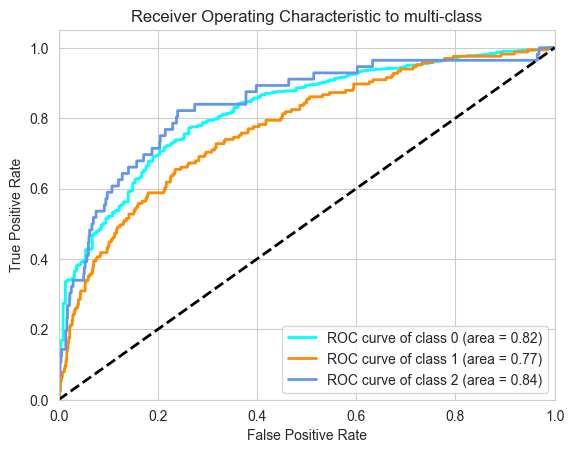

In [34]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import numpy as np

predictions = trainer.predict(test_dataset)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()

def plot_roc_curve(labels, probs):
    # 计算ROC曲线
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    # 将标签转换为One-hot编码
    test_labels_one_hot = np.eye(3)[labels]
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # 绘制ROC曲线
    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
                                                           ''.format(i, roc_auc[i]))
        
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(test_labels, probs)

## PR曲线

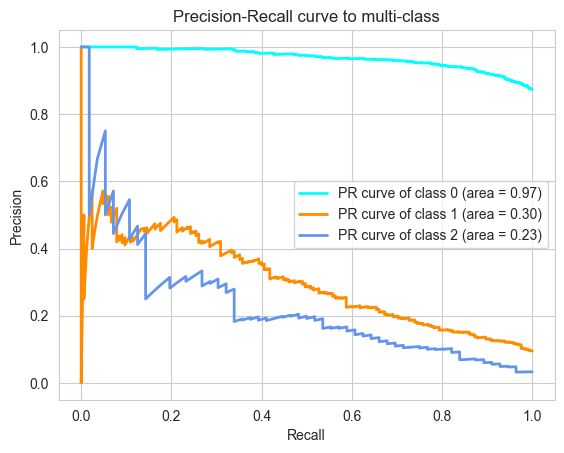

In [35]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curve(labels, probs):
    
    precision = {}
    recall = {}
    average_precision = {}
    test_labels_one_hot = np.eye(3)[labels]
    
    for i in range(3):
        precision[i], recall[i], _ = precision_recall_curve(test_labels_one_hot[:, i], probs[:, i])
        average_precision[i] = average_precision_score(test_labels_one_hot[:, i], probs[:, i])

    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(3), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2, label='PR curve of class {0} (area = {1:0.2f})'
                                                           ''.format(i, average_precision[i]))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve to multi-class')
    plt.legend(loc="best")
    plt.show()

plot_pr_curve(test_labels, probs)

## 混淆矩阵

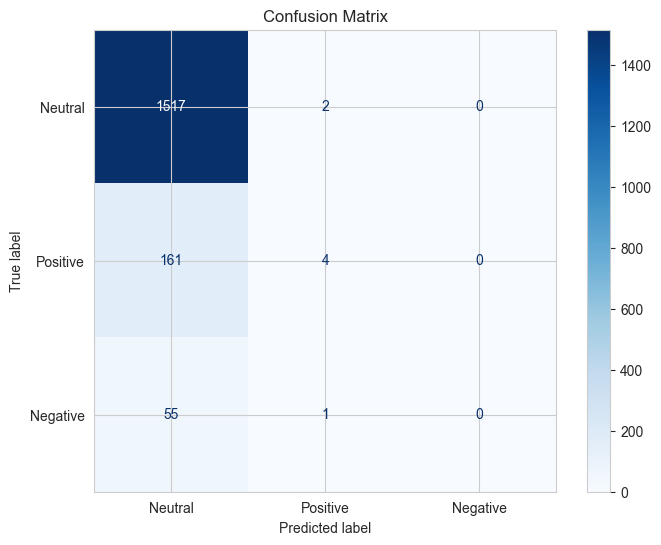

In [43]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='d', ax=ax)
    plt.title('Confusion Matrix')
    plt.show()
    
predicted_labels = np.argmax(predictions.predictions, axis=1)
plot_confusion_matrix(test_labels, predicted_labels, list(label2id.keys()))

## 误差分析

In [42]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        if loss_type == 'dsc_loss':
            loss_fct = MultiDSCLoss(alpha=1.0, smooth=1.0, reduction='none')
        elif loss_type == 'focal_loss':
            loss_fct = MultiFocalLoss(num_class=3, alpha=0.8, gamma=2.0, reduction='none')
        else:
            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        loss = loss_fct(output.logits, batch["label"].to(device))
    
    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

tokenized_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_data["validation"] = tokenized_data["validation"].map(forward_pass_with_label, batched=True, batch_size=16)
tokenized_data.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = tokenized_data["validation"][:][cols]
df_test["label"] = df_test["label"].map(id2label)
df_test["predicted_label"] = (df_test["predicted_label"].map(id2label))

Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

KeyError: "['text'] not in index"

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

In [ ]:
from torch.utils.data import DataLoader, ConcatDataset

# best_model_dir = './model/distilbert-base-uncased-finetuned-citation'
# trainer.save_model(best_model_dir)
# best_model = AutoModelForSequenceClassification.from_pretrained(best_model_dir).to(device)


# def predict_sentiment_score(model, dataset, batched=True, BATCH_SIZE=32, weights=[-0.5, 1, -1], shuffle=False):
#     '''
#     预测句子的情感
#     '''
#     results = []
#     sentiment_scores = []
#     model.eval()  # 将模型设置为评估模式

#     dataloader = DataLoader(dataset, BATCH_SIZE=BATCH_SIZE, shuffle=shuffle)

#     if batched:
#         with torch.no_grad():  # 不计算梯度，以加速和节省内存
#             for batch in dataloader:
#                 # 将批次数据移动到cuda
#                 batch = {k: v.to(device) for k, v in batch.items()}
#                 outputs = model(**batch)
#                 logits = outputs.logits
#                 probabilities = F.softmax(logits, dim=-1)
                
#                 logits_list = logits.tolist()
#                 probabilities_list = probabilities.tolist()
#                 results.extend(zip(logits_list, probabilities_list))
#     else:
#         with torch.no_grad():
#             inputs = tokenizer(dataset, return_tensors='pt', truncation=True, padding=True).to(device)
#             outputs = model(**inputs)
#             logits = outputs.logits
#             probabilities = F.softmax(logits, dim=-1)
#             logits_list = logits.tolist()
#             probabilities_list = probabilities.tolist()
#             results.extend(zip(logits_list, probabilities_list))

#     for _, softmax_probs in results:
#         softmax_probs_array = np.array(softmax_probs)
#         weights_array = np.array(weights)
#         score = np.sum(softmax_probs_array * weights_array)
#         score = max(min(score, 1), -1)
#         sentiment_scores.append(score)
#     return sentiment_scores

# weights=[-0.1, 1, -1]
# all_dataset = ConcatDataset([train_dataset, test_dataset, val_dataset])
# sentiment_scores = predict_sentiment_score(best_model, all_dataset, weights=weights, batched=True, BATCH_SIZE=1, shuffle=True) # 句子维度不一样就把BATCH_SIZE设为1
